In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [3]:
sns.set_style('whitegrid')

## Train Data

In [4]:
df_train = pd.read_csv(r'C:\Users\Mehul\Desktop\ml projects\new-york-city-taxi-fare-prediction\train.csv',nrows=200000, parse_dates=['pickup_datetime'])

## Exploratory Data Analysis

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                200000 non-null  object             
 1   fare_amount        200000 non-null  float64            
 2   pickup_datetime    200000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   200000 non-null  float64            
 4   pickup_latitude    200000 non-null  float64            
 5   dropoff_longitude  199999 non-null  float64            
 6   dropoff_latitude   199999 non-null  float64            
 7   passenger_count    200000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 12.2+ MB


In [6]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,11.342877,-72.506121,39.922326,-72.518673,39.925579,1.682445
std,9.837855,11.608097,10.048947,10.724226,6.751120,1.306730
min,-44.900000,-736.550000,-3116.285383,-1251.195890,-1189.615440,0.000000
25%,6.000000,-73.992050,40.735007,-73.991295,40.734092,1.000000
50%,8.500000,-73.981743,40.752761,-73.980072,40.753225,1.000000
75%,12.500000,-73.967068,40.767127,-73.963508,40.768070,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


In [7]:
df_train.dtypes

key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

## Data Pre-Processing 

Minimim Fare-Amount is Negative, so we have to remove these observations


In [8]:
df_train = df_train[df_train["fare_amount"] >= 0]

In [9]:
len(df_train)

199987

### Histogram of the fare amount

C:\Users\Mehul\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fare_amount'>

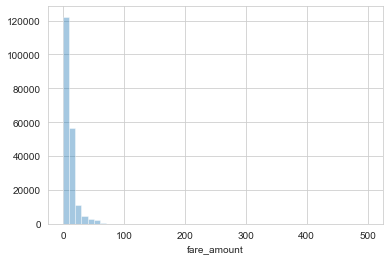

In [10]:
sns.distplot(df_train["fare_amount"], kde=False)

<AxesSubplot:xlabel='fare_amount'>

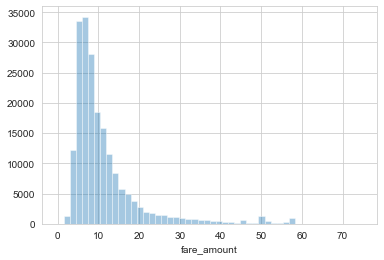

In [11]:
sns.distplot(df_train[df_train["fare_amount"] < 75]["fare_amount"], kde=False)

#### Notice small spikes between 40 & 60

### Remove Missing Data

In [12]:
print(df_train.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [13]:
df_train = df_train.dropna(how='any', axis='rows')

In [14]:
len(df_train)

199986

### Test Data

In [15]:
df_test = pd.read_csv(r'C:\Users\Mehul\Desktop\ml projects\new-york-city-taxi-fare-prediction\test.csv')

In [16]:
df_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [17]:
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


#### NewYork City coordinates are https://www.travelmath.com/cities/New+York,+NY

In [18]:
latitude = 40.7141667
longitude = -74.0063889

##### bounding box of interest by[long_min, long_max, latt_min, latt_max] using the minimum and maximum coordinates from test.csv

this will ensure that the trainig model will have the full range for the test set.

#### Minimum and Maximum Longitude Test set


In [19]:
print(min(df_test["pickup_longitude"].min(), df_test["dropoff_longitude"].min()))

-74.263242


In [20]:
print(max(df_test["pickup_longitude"].max(), df_test["dropoff_longitude"].max()))

-72.986532


In [21]:
print(min(df_train["pickup_longitude"].min(), df_train["dropoff_longitude"].min()))

-1251.19589


In [22]:
print(max(df_train["pickup_longitude"].max(), df_train["dropoff_longitude"].max()))

2140.60116


#### Minimum and Maximum Latitude test set

In [23]:
print(min(df_test["pickup_latitude"].min(), df_test["dropoff_latitude"].min()))

40.568973


In [24]:
print(max(df_test["pickup_latitude"].max(), df_test["dropoff_latitude"].max()))

41.709555


In [25]:
print(min(df_train["pickup_latitude"].min(), df_train["dropoff_latitude"].min()))

-3116.285383


In [26]:
print(max(df_train["pickup_latitude"].max(), df_train["dropoff_latitude"].max()))

1703.092772


### Function for selecting the bounding box

In [27]:
def select_within_boundingbox(df, BB):
    return ((df["pickup_longitude"] >= BB[0]) & (df["pickup_longitude"] <= BB[1]) & 
            (df["pickup_latitude"] >= BB[2]) & (df["pickup_latitude"] <= BB[3]) &
            (df["dropoff_longitude"] >= BB[0]) & (df["dropoff_longitude"] <= BB[1]) &
            (df["dropoff_latitude"] >= BB[2]) & (df["dropoff_latitude"] <= BB[3]))

### load image of NYC map for Visualization 

In [28]:
BB = (-74.3, -73.0, 40.6, 41.7)

In [29]:
nyc_map = plt.imread(r"C:\Users\Mehul\Desktop\ml projects\new-york-city-taxi-fare-prediction\map.png")

In [30]:
nyc_map.shape

(987, 970, 4)

In [31]:
df_train = df_train[select_within_boundingbox(df_train, BB)]

In [32]:
print("New Size {}".format(len(df_train)))

New Size 195612


In [33]:
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1,2,figsize=(16, 10))
    axs[0].scatter(df["pickup_longitude"], df["pickup_latitude"], alpha = alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup Locations')
    axs[0].imshow(nyc_map, extent=BB)
    
    axs[1].scatter(df["dropoff_longitude"], df["dropoff_latitude"] , alpha = alpha, c='b', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff Locations')
    axs[1].imshow(nyc_map, extent=BB)

### plotting training data on map

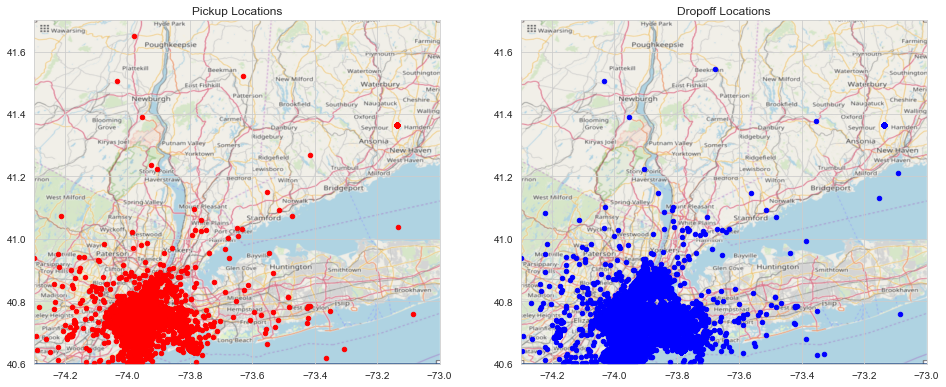

In [39]:
plot_on_map(df_train, BB, nyc_map, s=20, alpha=1)

### plotting testing data on map

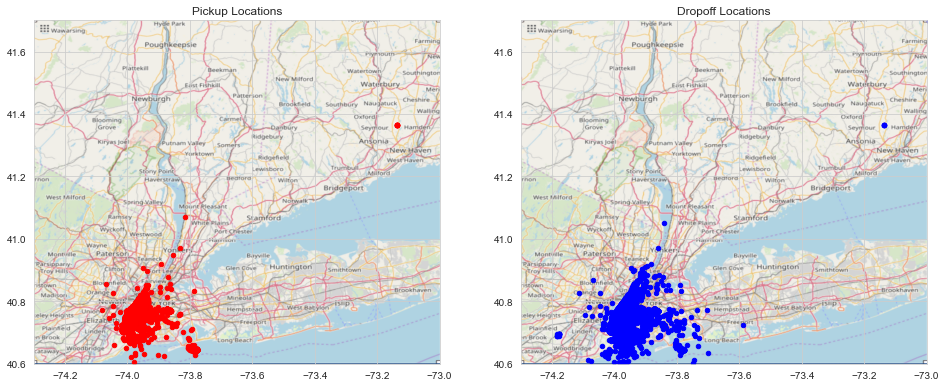

In [40]:
plot_on_map(df_test, BB, nyc_map, alpha=1.0, s=20)

## Scatter plot


In [41]:
def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = select_within_boundingbox(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.01, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=0.01, alpha=0.5)


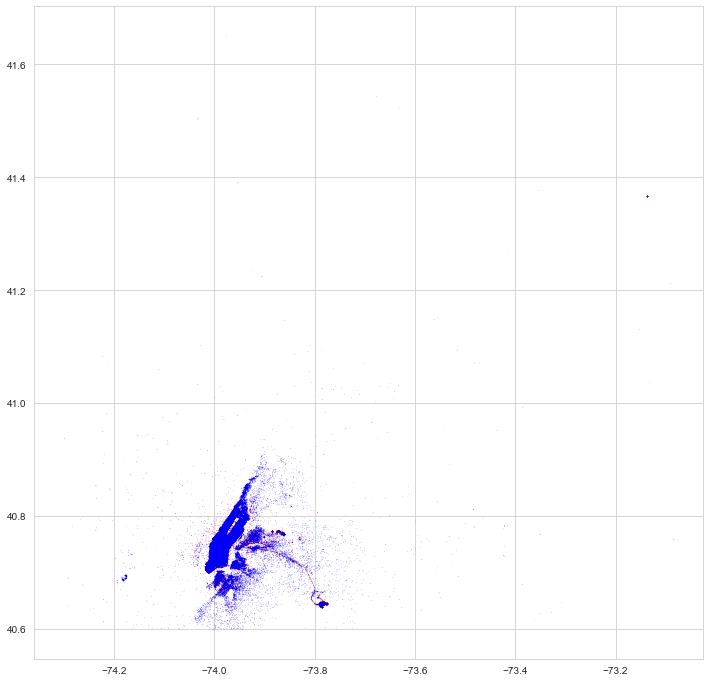

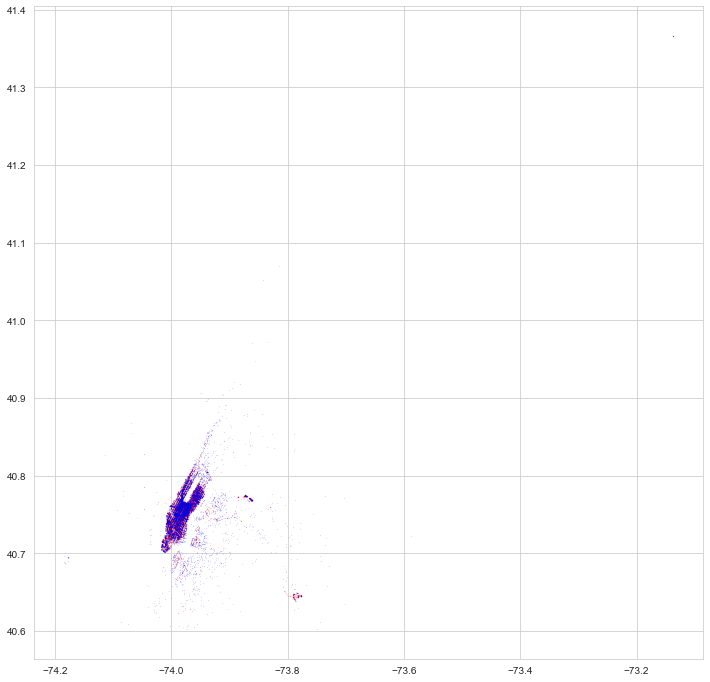

In [42]:

plot_hires(df_train, BB)
plot_hires(df_test, BB)

#### add time informtion

In [70]:

df_train['year'] = df_train["pickup_datetime"].apply(lambda t: t.year)
df_train['weekday'] = df_train["pickup_datetime"].apply(lambda t: t.weekday())
df_train['hour'] = df_train["pickup_datetime"].apply(lambda t: t.hour)

## Distance and Time Visualization

#### 1. The longer the distance between the pickup and  dropoff locations, the higher the fare.
#### 2. Some trips from/to an airport are fixed fee.
#### 3. Fare at night is different from the day time.

In [71]:
from math import cos, asin, sqrt, pi

def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p) * np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p))/2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) #2*R*asin...

#### the longer the distance between pickup and dropoff location, higher the fare. Adding new column to the dataframe with distance in  miles.

In [72]:
df_train['distance_miles'] = distance(df_train["pickup_latitude"], df_train["pickup_longitude"],df_train["dropoff_latitude"],df_train["dropoff_longitude"])

In [73]:
df_train.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,disrance_miles,distance_miles,fare_per_mile,year,weekday,hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.640487,0.640487,7.025903,2009,0,17
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,5.250670,5.250670,3.218637,2010,1,16


Text(0.5, 1.0, 'histogram ride distance in miles')

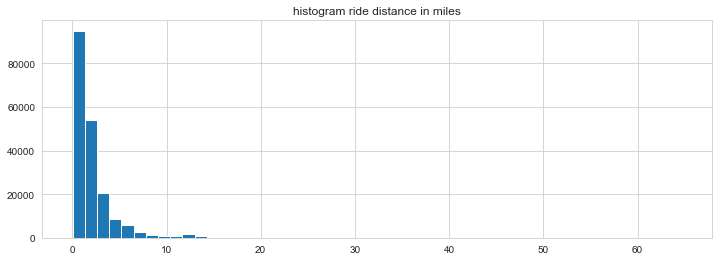

In [74]:
df_train["distance_miles"].hist(bins=50, figsize=(12,4))
plt.title("histogram ride distance in miles")

In [75]:
df_train["distance_miles"].describe()

count    192447.000000
mean          2.097265
std           2.356285
min           0.050056
25%           0.804144
50%           1.361119
75%           2.454518
max          64.644331
Name: distance_miles, dtype: float64

##### it seems most rides are just short rides, with a small peak at 13 miles. this peak could be due to airport drives

In [76]:
df_train.groupby('passenger_count')['distance_miles','fare_amount'].mean()


C:\Users\Mehul\AppData\Local\Temp/ipykernel_1516/1284948757.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_train.groupby('passenger_count')['distance_miles','fare_amount'].mean()


,distance_miles,fare_amount
passenger_count,,
0,1.849479,9.124675
1,2.070317,11.126512
2,2.205497,11.751668
3,2.098024,11.338895
4,2.160669,11.628724
5,2.099233,11.186980
6,2.192804,12.404019


### scatter plot distance vs fare

Text(0.5, 1.0, 'Zoom in on distance < 15 mile and fare < $100')

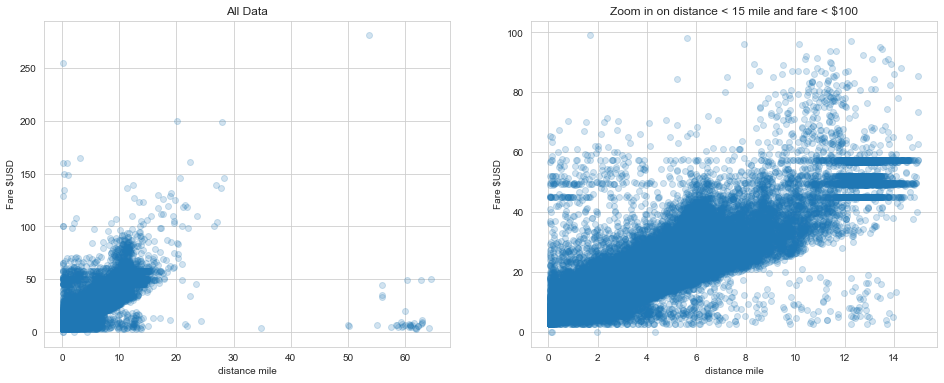

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(df_train["distance_miles"], df_train["fare_amount"], alpha=0.2)
axs[0].set_xlabel("distance mile")
axs[0].set_ylabel("Fare $USD")
axs[0].set_title("All Data")

# Zoom-in some part of the data
idx = ((df_train['distance_miles'] < 15) & (df_train["fare_amount"] < 100))
axs[1].scatter(df_train[idx]["distance_miles"], df_train[idx]["fare_amount"], alpha=0.2)
axs[1].set_xlabel("distance mile")
axs[1].set_ylabel("Fare $USD")
axs[1].set_title("Zoom in on distance < 15 mile and fare < $100")

### Few Obervations -

#### There are trips with zero distance but with a non-zero fare. Could this be trips from and to the same location? Predicting these fares will be difficult as there is likely not sufficient information in the dataset.
#### There are some trips with >50 miles travel distance but low fare. Perhaps these are discounted trips.
#### The horizontal lines in the right plot might indicate again the fixed fare trips to/from JFK airport.
#### Overall there seems to be a (linear) relation between distance and fare with an average rate of +/- 100/20 = 5 $USD/mile

In [78]:
# remove datapoints with distance <0.05 miles
idx = (df_train["distance_miles"] >= 0.05)
print('Old size: %d' % len(df_train))
df_train = df_train[idx]
print('New size: %d' % len(df_train))

Old size: 192447
New size: 192447


### JKF airport coordinates https://www.travelmath.com/airport/JFK

In [79]:
jfk = (-73.7822222222,40.6441666667)
nyc = (-74.0063889, 40.7141667)

In [80]:
def plot_location_fare(loc, name, range=1.5):
    # select all datapoints with dropoff location within range of airport
    fig, axs = plt.subplots(1,2, figsize=(14,5))
    idx = (distance(df_train["pickup_latitude"], df_train["pickup_longitude"], loc[1], loc[0]) < range)
    df_train[idx]["fare_amount"].hist(bins = 100, ax=axs[0])
    axs[0].set_xlabel("Fare $USD")
    axs[0].set_title("Histogram pickup location within {} miles of {}".format(range, name))
    
    idx = (distance(df_train["dropoff_latitude"], df_train["dropoff_longitude"], loc[1], loc[0]) < range)
    df_train[idx]["fare_amount"].hist(bins=100, ax=axs[1])
    axs[1].set_xlabel("Fare $USD")
    axs[1].set_title("Histogram dropoff location within {} miles of {}".format(range,name))

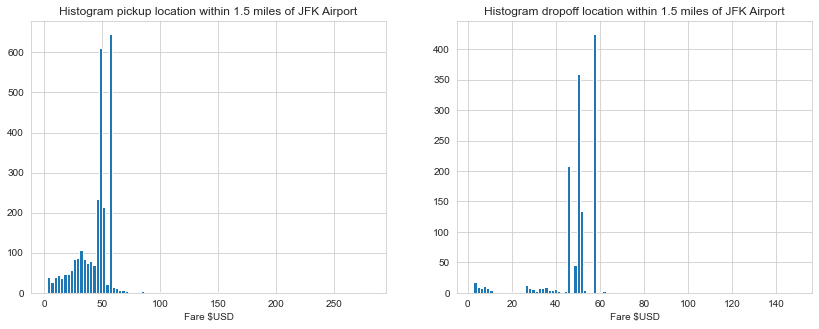

In [81]:
plot_location_fare(jfk, 'JFK Airport')

In [82]:
#Other Airports
ewr = (-74.175, 40.69) #Newark Liberty International Airport https://www.travelmath.com/airport/EWR
lgr = (-73.87, 40.77) #Laguardia Airport, https://www.travelmath.com/airport/LGA

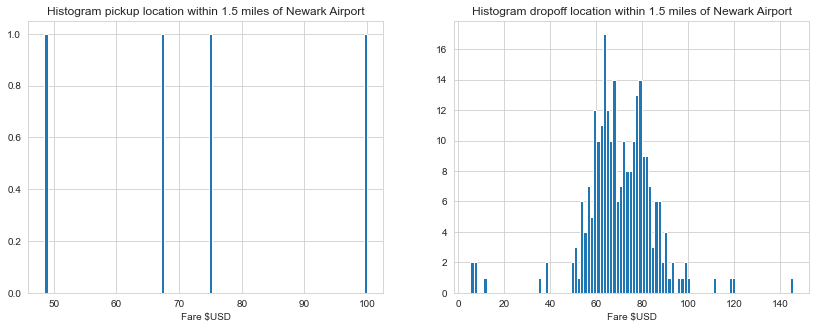

In [83]:
plot_location_fare(ewr, 'Newark Airport')

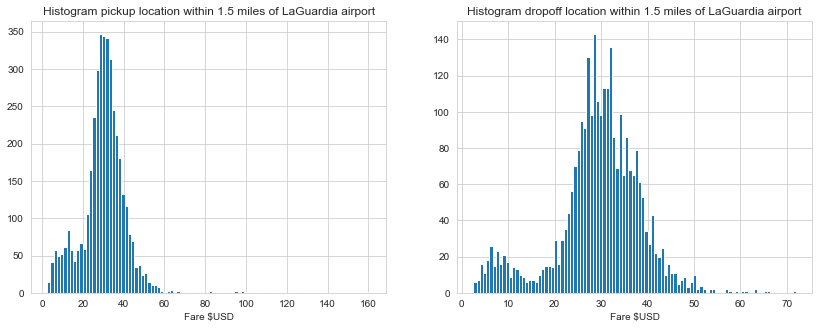

In [84]:
plot_location_fare(lgr, 'LaGuardia airport')


### fare at night vs day time

In [85]:
df_train["fare_per_mile"] = df_train["fare_amount"] / df_train["distance_miles"]
df_train["fare_per_mile"].describe()

count    192447.000000
mean          7.404693
std          15.918010
min           0.000000
25%           4.771146
50%           6.137379
75%           8.072801
max        3812.571628
Name: fare_per_mile, dtype: float64

Text(0, 0.5, 'fare per distance in mile')

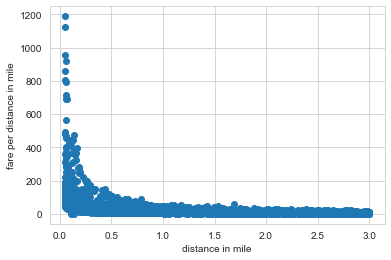

In [86]:
idx = (df_train["distance_miles"] < 3) & (df_train["fare_amount"] < 100)
plt.scatter(df_train[idx]["distance_miles"], df_train[idx]["fare_per_mile"])
plt.xlabel("distance in mile")
plt.ylabel("fare per distance in mile")

### pivot table



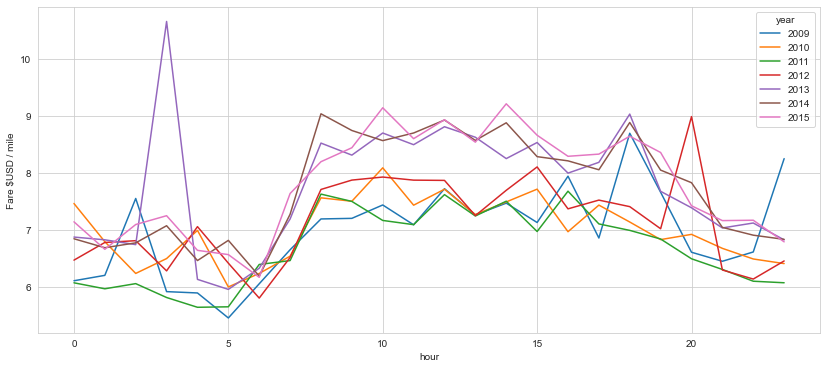

In [87]:

df_train.pivot_table("fare_per_mile", index="hour", columns="year").plot(figsize=(14,6))
plt.ylabel("Fare $USD / mile");

### fare and time dependency per year

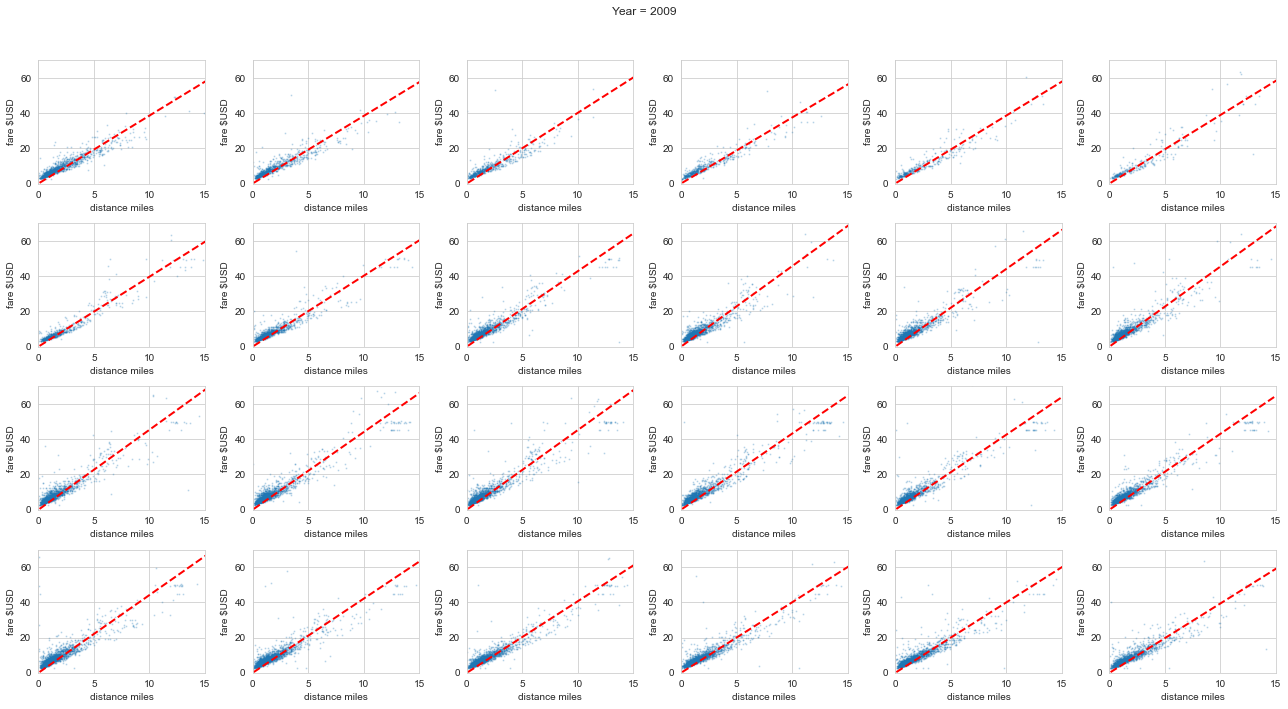

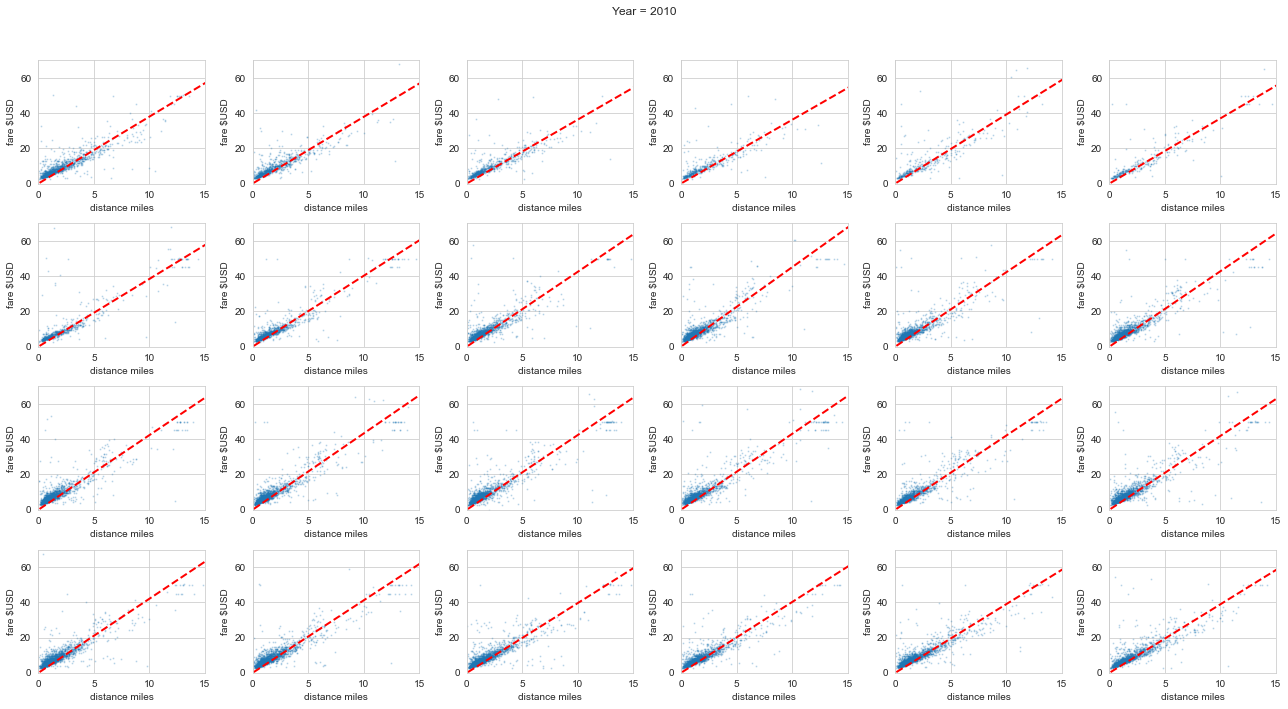

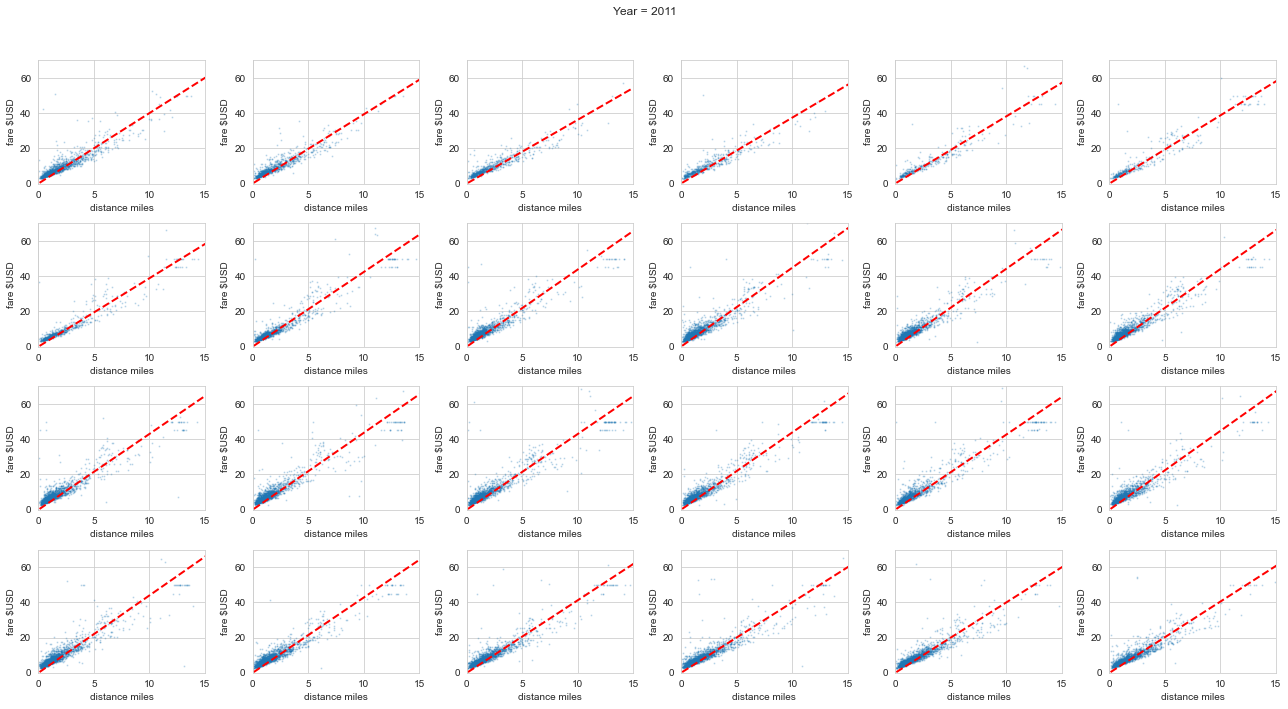

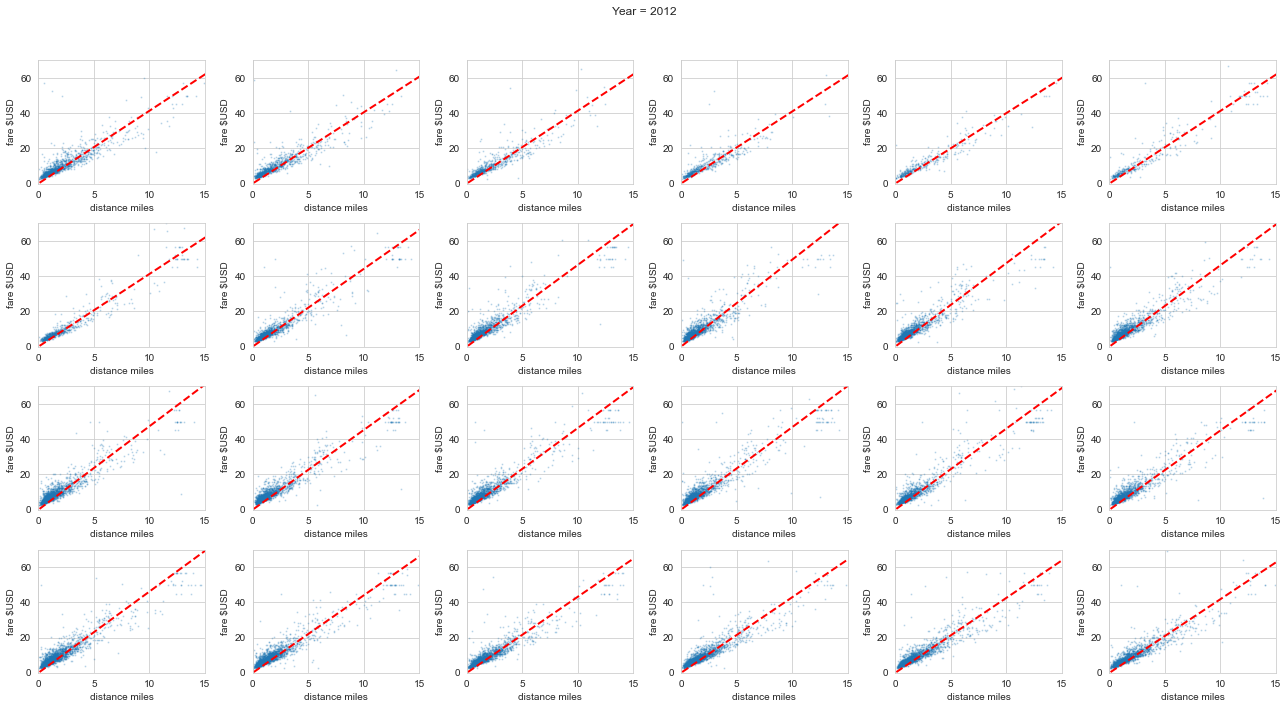

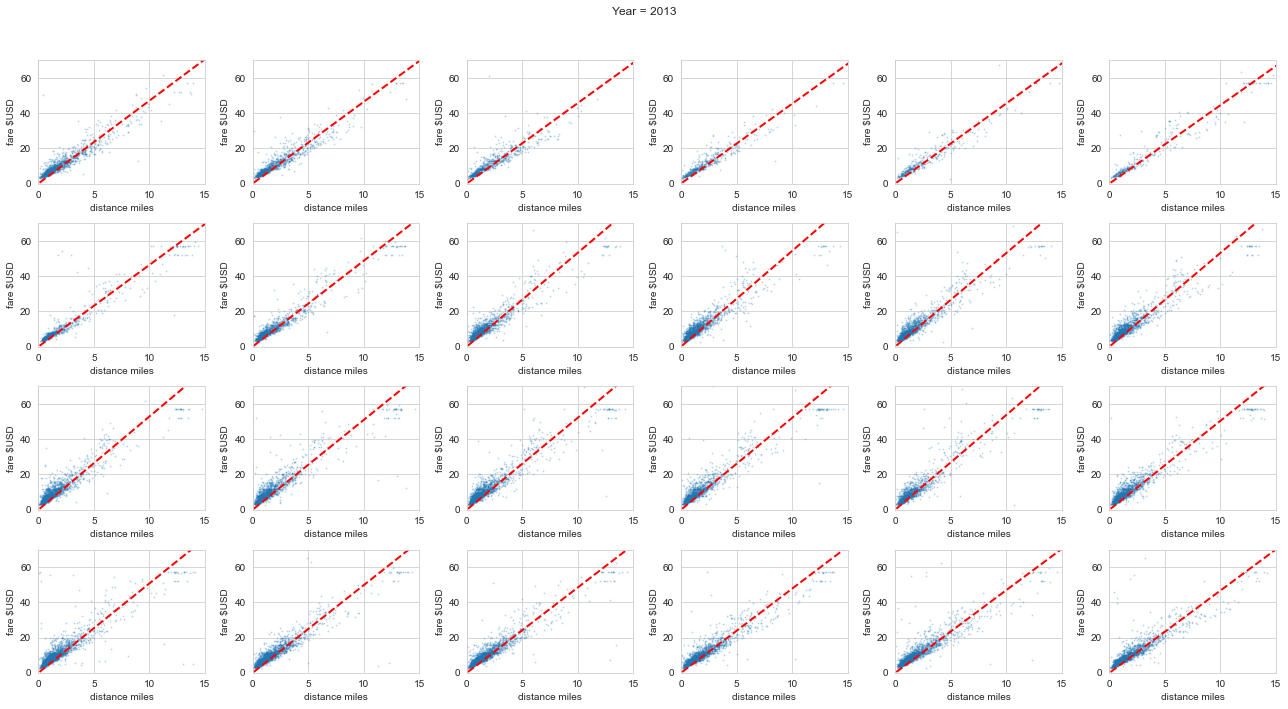

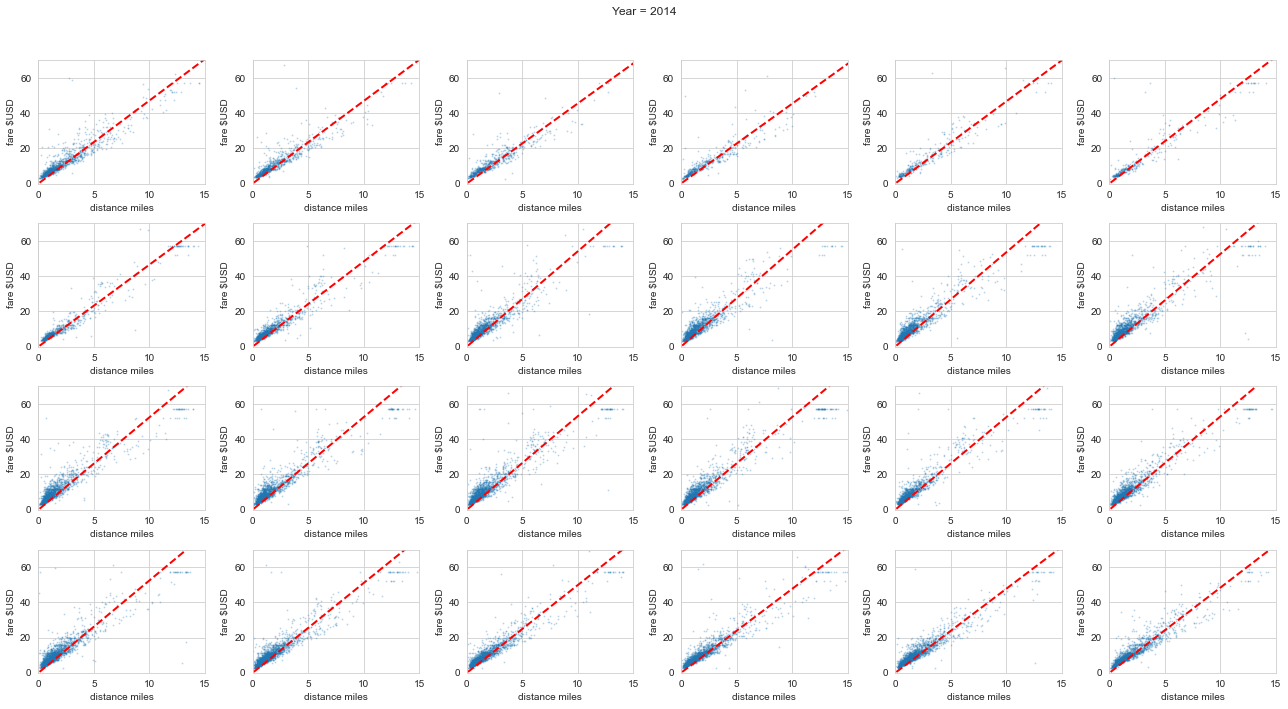

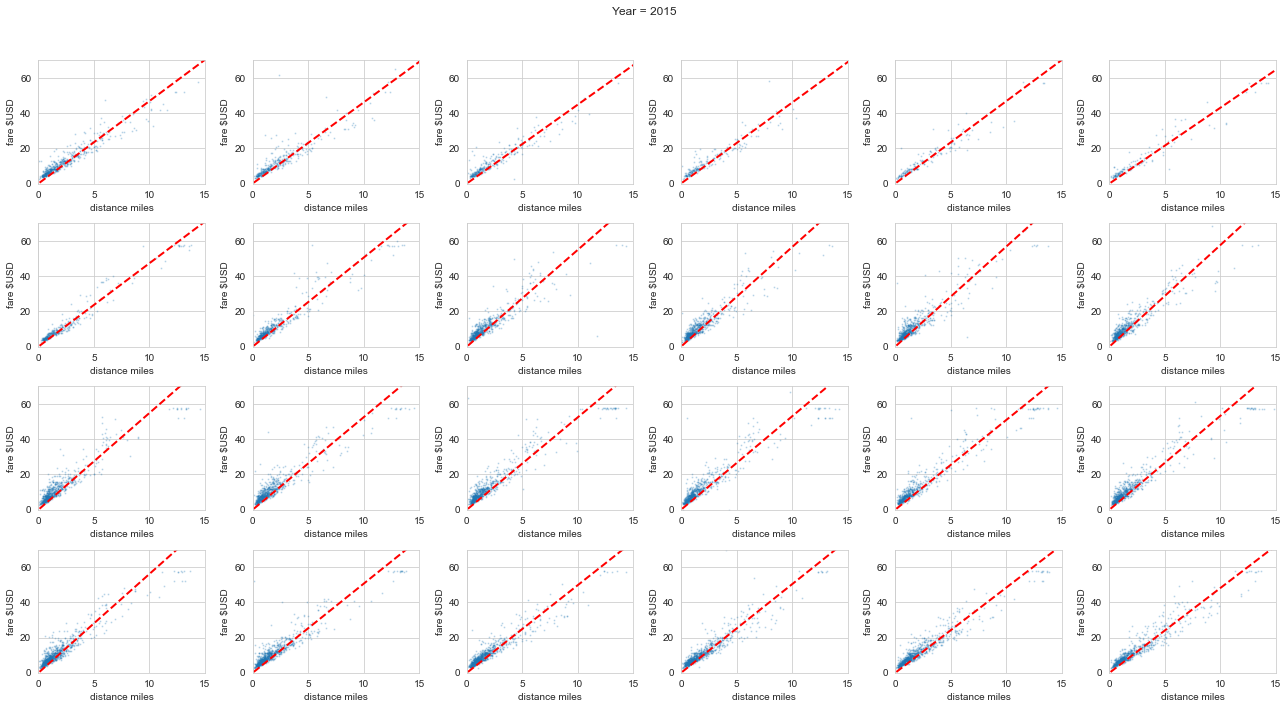

In [88]:
from sklearn.linear_model import LinearRegression

# plot all years
for year in df_train["year"].unique():
    
    # create figure
    fig, axs = plt.subplots(4, 6, figsize=(18, 10))
    axs = axs.ravel()
    
    # plot for all hours
    
    for h in range(24):
        idx = (df_train["distance_miles"] < 15) & (df_train["fare_amount"] < 100) & (df_train["hour"] == h) & \
              (df_train["year"] == year)
        axs[h].scatter(df_train[idx]["distance_miles"], df_train[idx]["fare_amount"], alpha=0.2, s=1)
        axs[h].set_xlabel('distance miles')
        axs[h].set_ylabel('fare $USD')
        axs[h].set_xlim((0, 15))
        axs[h].set_ylim((0, 70))
        
        model = LinearRegression(fit_intercept=False)
        
        X, y = df_train[idx]["distance_miles"].values.reshape(-1,1), df_train[idx]["fare_amount"].values
        model.fit(X, y)
        xx = np.linspace(0.1, 25, 100)
        axs[h].plot(xx, model.predict(xx.reshape(-1,1)), '--', c='r', lw=2)
        
    plt.suptitle("Year = {}".format(year))
    plt.tight_layout(rect=[0, 0, 1, 0.95]);

### Relevance of direction for calculation of fare amount

In [89]:
df_train["delta_lon"] = df_train["pickup_longitude"] - df_train["dropoff_longitude"]
df_train["delta_lat"] = df_train["pickup_latitude"] - df_train["dropoff_latitude"]

### select tips in Manhattan


Text(0.5, 1.0, 'log1p(fare_amount)')

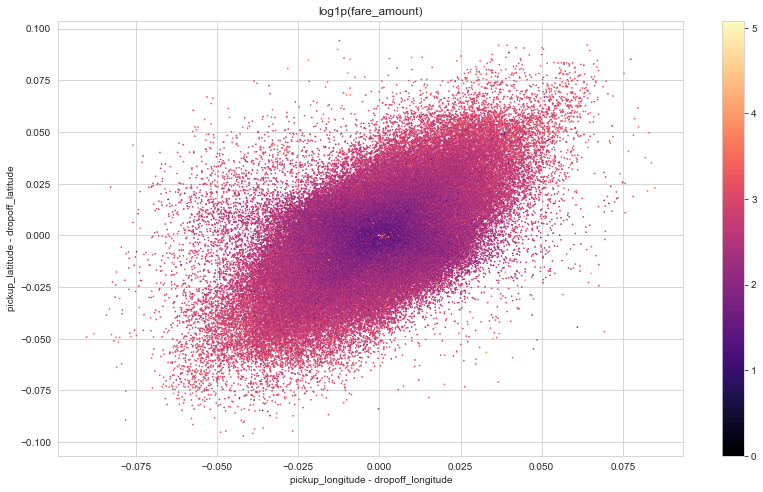

In [90]:
BB_manhattan = (-74.025, -73.925, 40.7, 40.8)
idx_manhattan = select_within_boundingbox(df_train, BB_manhattan)
plt.figure(figsize=(14,8))
plt.scatter(df_train[idx_manhattan]["delta_lon"], df_train[idx_manhattan]["delta_lat"], s=0.5, alpha=1.0,
            c=np.log1p(df_train[idx_manhattan]["fare_amount"]), cmap="magma")
plt.colorbar()
plt.xlabel('pickup_longitude - dropoff_longitude')
plt.ylabel('pickup_latitude - dropoff_latitude')
plt.title('log1p(fare_amount)')

###### Looks like direction of the trip seems to matter. Direction of a trip, from 180 to -180 degrees. Horizontal axes = 0 degrees

In [91]:
def calculate_direction(d_lon, d_lat):
    result = np.zeros(len(d_lon))
    l = np.sqrt(d_lon**2 + d_lat**2)
    result[d_lon>0] = (180/np.pi)*np.arcsin(d_lat[d_lon>0]/l[d_lon>0])
    idx = (d_lon<0) & (d_lat>0)
    result[idx] = 180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    idx = (d_lon<0) & (d_lat<0)
    result[idx] = -180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    return result

In [92]:
df_train['direction'] = calculate_direction(df_train.delta_lon, df_train.delta_lat)

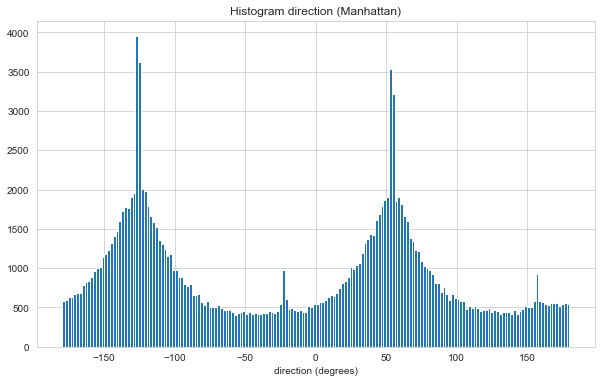

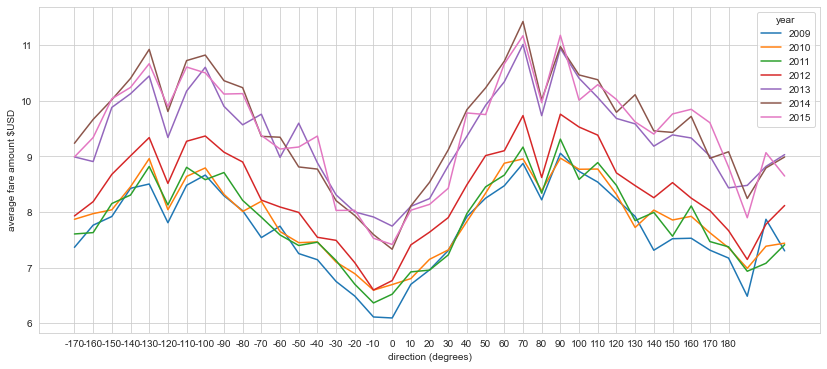

In [93]:
# plot histogram of directions
plt.figure(figsize=(10,6))
df_train[idx_manhattan].direction.hist(bins=180)
plt.xlabel('direction (degrees)')
plt.title('Histogram direction (Manhattan)')

# plot direction vs average fare amount
fig, ax = plt.subplots(1, 1, figsize=(14,6))
direc = pd.cut(df_train[idx_manhattan]['direction'], np.linspace(-180, 180, 40))

df_train[idx_manhattan].pivot_table('fare_amount', index=[direc], columns='year', aggfunc='mean').plot(ax=ax)

plt.xlabel('direction (degrees)')
plt.xticks(range(36), np.arange(-170, 190, 10))
plt.ylabel('average fare amount $USD');

### fare varies with pickup location

In [94]:
# add new column to dataframe with distance in mile
df_train['distance_to_center'] = distance(nyc[1], nyc[0], df_train["pickup_latitude"], df_train["pickup_longitude"])
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,disrance_miles,distance_miles,fare_per_mile,year,weekday,hour,delta_lon,delta_lat,direction,distance_to_center
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.640487,0.640487,7.025903,2009,0,17,-0.002701,0.009041,106.633523,8.502079
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,5.250670,5.250670,3.218637,2010,1,16,-0.036780,-0.070701,-117.484306,0.543185
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.863411,0.863411,6.601723,2011,3,0,0.008504,0.010708,51.544361,3.482099
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,1.739386,1.739386,4.426850,2012,5,4,0.004437,-0.024949,-79.915791,1.654108
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.242218,1.242218,4.266560,2010,1,7,-0.011440,-0.015754,-125.985832,4.225834


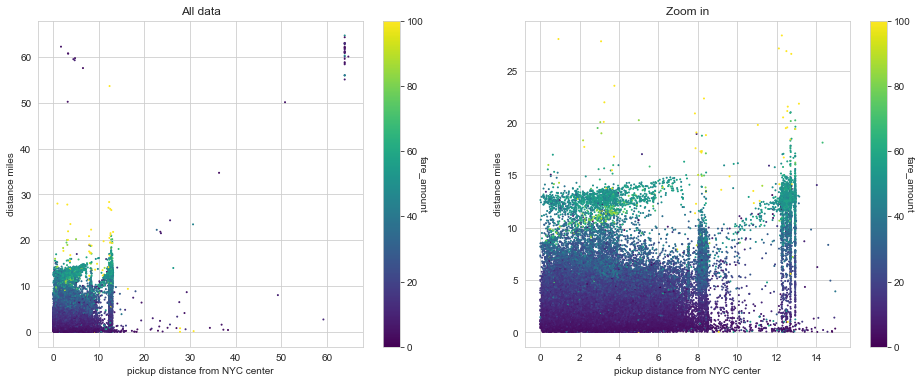

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
im = axs[0].scatter(df_train["distance_to_center"], df_train["distance_miles"], c=np.clip(df_train["fare_amount"], 0, 100), 
                     cmap='viridis', alpha=1.0, s=1)

axs[0].set_xlabel('pickup distance from NYC center')
axs[0].set_ylabel('distance miles')
axs[0].set_title('All data')

cbar = fig.colorbar(im, ax=axs[0])
cbar.ax.set_ylabel('fare_amount', rotation=270)


idx = (df_train["distance_to_center"] < 15) & (df_train["distance_miles"] < 35)
im = axs[1].scatter(df_train[idx]["distance_to_center"], df_train[idx]["distance_miles"], 
                     c=np.clip(df_train[idx]["fare_amount"], 0, 100), cmap='viridis', alpha=1.0, s=1)
axs[1].set_xlabel('pickup distance from NYC center')
axs[1].set_ylabel('distance miles')
axs[1].set_title('Zoom in')
cbar = fig.colorbar(im, ax=axs[1])
cbar.ax.set_ylabel('fare_amount', rotation=270);

### There is a lot of 'green' dots, which is about 50 to 60 fare amount near 13 miles distance of NYC center of distrance of trip. This could be due to trips from/to JFK airport

### baseline model and submission


In [97]:
# add new column to dataframe with distance in km
df_test['distance_miles'] = distance(df_test["pickup_latitude"], df_test["pickup_longitude"], 
                                     df_test["dropoff_latitude"], df_test["dropoff_longitude"])
df_test['distance_to_center'] = distance(nyc[1], nyc[0], df_test["dropoff_latitude"], df_test["dropoff_longitude"])
df_test['hour'] = df_test["pickup_datetime"].apply(lambda t: pd.to_datetime(t).hour)
df_test['year'] = df_test["pickup_datetime"].apply(lambda t: pd.to_datetime(t).year)
df_test['weekday'] = df_test["pickup_datetime"].apply(lambda t: pd.to_datetime(t).weekday())

In [98]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,disrance_miles,distance_miles,fare_per_mile,year,weekday,hour,delta_lon,delta_lat,direction,distance_to_center
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.640487,0.640487,7.025903,2009,0,17,-0.002701,0.009041,106.633523,8.502079
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,5.250670,5.250670,3.218637,2010,1,16,-0.036780,-0.070701,-117.484306,0.543185
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.863411,0.863411,6.601723,2011,3,0,0.008504,0.010708,51.544361,3.482099
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,1.739386,1.739386,4.426850,2012,5,4,0.004437,-0.024949,-79.915791,1.654108
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.242218,1.242218,4.266560,2010,1,7,-0.011440,-0.015754,-125.985832,4.225834


In [99]:
df_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_miles,distance_to_center,hour,year,weekday
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,1.443607,2.431036,13,2015,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,1.507044,1.773728,13,2015,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1,0.384398,2.615229,11,2011,5
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1,1.218529,2.720018,21,2012,5
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1,3.347514,2.289611,21,2012,5


In [100]:
# define dataset
# select points 15 miles near NYC center and remove zero passenger datapoints
idx = (df_train["distance_to_center"] < 15) & (df_train["passenger_count"] != 0)

features = ['year', 'hour', 'distance_miles', 'passenger_count','weekday','distance_to_center']

X = df_train[idx][features].values
y = df_train[idx]['fare_amount'].values

In [101]:
print(X.shape, y.shape)

(191672, 6) (191672,)


In [102]:
# define some handy analysis support function
from sklearn.metrics import mean_squared_error, explained_variance_score

def plot_prediction_analysis(y, y_pred, figsize=(10,4), title=''):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].scatter(y, y_pred)
    mn = min(np.min(y), np.min(y_pred))
    mx = max(np.max(y), np.max(y_pred))
    axs[0].plot([mn, mx], [mn, mx], c='red')
    axs[0].set_xlabel('$y$')
    axs[0].set_ylabel('$\hat{y}$')
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    evs = explained_variance_score(y, y_pred)
    axs[0].set_title('rmse = {:.2f}, evs = {:.2f}'.format(rmse, evs))
    
    axs[1].hist(y-y_pred, bins=50)
    avg = np.mean(y-y_pred)
    std = np.std(y-y_pred)
    axs[1].set_xlabel('$y - \hat{y}$')
    axs[1].set_title('Histrogram prediction error, $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(avg, std))
    
    if title!='':
        fig.suptitle(title)

In [103]:
# create training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

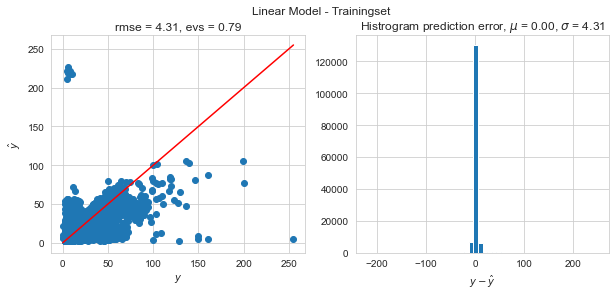

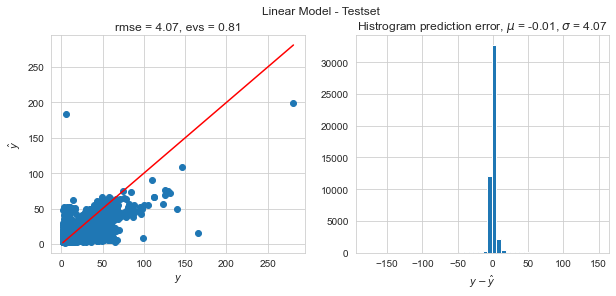

In [104]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

model_lin = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ))

model_lin.fit(X_train, y_train)

y_train_pred = model_lin.predict(X_train)

plot_prediction_analysis(y_train, y_train_pred, title='Linear Model - Trainingset')

y_test_pred = model_lin.predict(X_test)
plot_prediction_analysis(y_test, y_test_pred, title='Linear Model - Testset')

### kaggle submission


In [105]:
# define dataset
XTEST = df_test[features].values

In [106]:
y_pred_final = model_lin.predict(XTEST)

submission = pd.DataFrame(
    {
        'key': df_test["key"], 
        'fare_amount': y_pred_final
    },
    columns = ['key', 'fare_amount'])
submission.to_csv(r"C:\Users\Mehul\Desktop\ml projects\new-york-city-taxi-fare-prediction\submission.csv", index = False)
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.561678
1,2015-01-27 13:08:24.0000003,10.689142
2,2011-10-08 11:53:44.0000002,4.460974
3,2012-12-01 21:12:12.0000002,8.092290
4,2012-12-01 21:12:12.0000003,15.720683
